In [1]:
from skimage.filters import threshold_otsu
from joblib import Parallel, delayed 
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage import transform
from scipy.io import loadmat
import itertools,operator
from scipy import signal
from tqdm import tqdm
import numpy as np
import argparse
import time
import h5py
import math
import sys
import cv2
import os

In [2]:
def readDCA1000_1642(fileName):
  # global variables
  #change based on sensor config
  numADCSamples = 256; # number of ADC samples per chirp
  numADCBits = 16; # number of ADC bits per sample
  numRX = 4; # number of receivers
  numLanes = 2; # do not change. number of lanes is always 2
  isReal = 0; # set to 1 if real only data, 0 if complex data0

  # read .bin file
  with open(fileName, "rb") as fid:
      adcData = np.array(np.frombuffer(fid.read(), dtype=np.int16))
      
  # if 12 or 14 bits ADC per sample compensate for sign extension
  if numADCBits != 16:
      l_max = 2**(numADCBits-1)-1
      adcData[adcData > l_max] -= 2**numADCBits

  fileSize = adcData.shape[0]
  
  # real data reshape, filesize = numADCSamples*numChirps
  if isReal:
    numChirps = int(fileSize/numADCSamples/numRX)
    #create column for each chirp
    LVDS = np.reshape(adcData, (numADCSamples*numRX, numChirps), order='F').transpose()
  else:
    # for complex data
    # filesize = 2 * numADCSamples*numChirps
    numChirps = int(fileSize/2/numADCSamples/numRX)
    LVDS = np.zeros(int(fileSize/2)).astype(np.complex)
    # combine real and imaginary part into complex data
    # read in file: 2I is followed by 2Q
    LVDS[::2]  = adcData[::4]  + np.complex(0,1)*adcData[2::4]
    LVDS[1::2] = adcData[1::4] + np.complex(0,1)*adcData[3::4]
    # create column for each chirp
    # each row is data from one chirp
    LVDS = np.reshape(LVDS, (numADCSamples*numRX, numChirps), order='F').transpose()

  # organize data per RX
  adcData = np.zeros((numRX,numChirps*numADCSamples)).astype(np.complex)
  for row in range(numRX):
      for i in range(numChirps):
        adcData[row, i*numADCSamples:((i+1)*numADCSamples)] = LVDS[i, row*numADCSamples:((row+1)*numADCSamples)]
        
  return adcData

def read_samples(dataset_path, classes=None, num_samples=50, num_days=5, endswith=".bin"):
  if classes is None:
      classes = sorted([f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f)) and not f.startswith('.')])
  datapaths, labels = list(), list()
  for c in classes:
    c_dir = os.path.join(dataset_path, c)
    dates = sorted(os.listdir(c_dir))[:num_days]
    if (len(dates)) < num_days:
      raise NameError("Not enough days for subject: {}".format(c))
    for date in dates:
      samples = sorted(os.listdir(os.path.join(c_dir, date)))
      samples = [sample for sample in samples if sample.endswith(endswith)]
      samples = samples[:num_samples]
      if (len(samples)) < num_samples:
        raise NameError("Not enough samples for subject: {}".format(c))
      for sample in samples:
        datapaths.append(os.path.join(c_dir, date, sample))
        labels.append([classes.index(c), dates.index(date)])
  return datapaths, labels, classes

def fspecial_gaussian(size=15, sigma=2):
    kernel = np.fromfunction(lambda x, y: (1/(2*math.pi*sigma**2)) * math.e ** ((-1*((x-(size-1)/2)**2+(y-(size-1)/2)**2))/(2*sigma**2)), (size, size))
    kernel /= np.sum(kernel)
    return kernel

def get_range_mask(range_map):
  og_shape = range_map.shape
  
  #resize
  range_map = transform.resize(range_map, (224, 224), mode='reflect', anti_aliasing=True)
  
  #smooth and threshold
  range_map = ndi.gaussian_filter(range_map, sigma=5)
  thresh = threshold_otsu(range_map)
  range_map = range_map > thresh
  
  #find largest contour
  contours = cv2.findContours(range_map.astype(np.uint8),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)[-2]
      
  c = max(contours, key = cv2.contourArea)
  mask = np.zeros_like(range_map).astype(np.uint8)
  cv2.drawContours(mask, c, -1, (255, 255, 255), 1)
  return transform.resize(mask, og_shape, mode='reflect', anti_aliasing=True) 

def get_spectrogram(fname, label, mat_file=False):
    if mat_file:
      iq_data = loadmat(fname)["ans"]
    else:
      if (os.path.getsize(fname) == 188416000):
        iq_data = readDCA1000_1642(fname)
      else:
        return np.array([]), label 
    
    data = iq_data[0,:].reshape((-1, num_frame), order="F")
    
    tmp = []
    for j in range(num_frame):
        tmp.append(data[:, j].reshape((num_adc, num_chirp), order="F"))
    data = np.hstack(tmp)
    
    data = (data.transpose()*signal.hann(num_adc)).transpose()
    range_matrix = np.fft.fft(data, axis=0)
        
    b, a = signal.butter(8, 50/(fs/2), 'high')
    range_matrix = range_matrix[range_min:range_max]
    for j in range(range_matrix.shape[0]):
        range_matrix[j, :] = signal.lfilter(b, a, range_matrix[j,:], axis=0)    
    
    range_matrix_tmp = np.abs(range_matrix)
    range_matrix_tmp = (20*np.log(range_matrix_tmp/np.max(range_matrix_tmp)))
    range_mask       = get_range_mask(range_matrix_tmp)
    plt.imshow(transform.resize(range_matrix_tmp, (224, 224), mode='reflect', anti_aliasing=True))
    
    start = 0
    while not (np.where(range_mask[start] > 0)[0].shape[0] > 0):
      start += 1
    range_matrix = range_matrix[start:]
    
    range_matrix_tmp = np.abs(range_matrix)
    range_matrix_tmp = (20*np.log(range_matrix_tmp/np.max(range_matrix_tmp)))
    range_mask       = get_range_mask(range_matrix_tmp)
    
    if (range_matrix.shape[0] < 1):
      return np.array([]), label
    
    if (np.where(range_mask[0] > 0)[0].shape[0] > 0):
      direc = -1*(np.where(range_mask[0] > 0)[0][0] < range_mask.shape[1]/2)
    else:
      return np.array([]), label
    
    for j in range(range_matrix.shape[0]):
      if not (len(np.where(range_mask[j] > 0)[0]) > 0):
        return np.array([]), label
      
      if direc:
        range_matrix[j, :np.where(range_mask[j] > 0)[0][direc]-5*attention_window_length] = 0
        range_matrix[j, np.where(range_mask[j] > 0)[0][direc]:] = 0   
      else:
        range_matrix[j, :np.where(range_mask[j] > 0)[0][direc]] = 0
        range_matrix[j, np.where(range_mask[j] > 0)[0][direc]+5*attention_window_length:] = 0  
        
    if(range_matrix.shape[0] < 1):
        return np.array([]), label

    for j in range(range_matrix.shape[0]):
        f_vec, t, S = signal.spectrogram(range_matrix[j,:], 
                                        fs=fs, 
                                        window=spec_window,
                                        noverlap=noverlap, 
                                        nfft=nfft,
                                        return_onesided=False,
                                        mode="complex")
        
        if (j == 0):
            S_new_all = np.abs(S)
        else:
            S_new_all += np.abs(S)
            
    S_new_all = np.roll(S_new_all, int(S_new_all.shape[0]/2), axis=0)
    
    sums = np.sum(S_new_all, 0)
    sum_inds = np.where(sums == 0)[0]
    sums[sum_inds] = 1
    fix_arr = np.ones_like(sums)
    fix_arr[sum_inds] = 0

    S_new_all /= sums
    S_new_all *= fix_arr
    S_new_all -= np.mean(S_new_all)
    S_new_all[np.where(S_new_all < 0)] = 0

    S_new_all = ndi.convolve(S_new_all, fspecial_gaussian(), mode='nearest')
    S_new_all[np.where(S_new_all <= 0)] = 1e-9
    S_new_all = 20*np.log10(S_new_all)
    
    #get longest sequence of good data 
    tmp = ~(S_new_all.astype(np.int32)+180).any(axis=0) == 0
    r = max((list(y) for (x,y) in itertools.groupby((enumerate(tmp)),operator.itemgetter(1)) if x == 1), key=len)
    S_new_all = S_new_all[:, r[0][0]:r[-1][0]]

    if direc == 0:
      S_new_all = S_new_all[128:int(S_new_all.shape[0]/2), int(S_new_all.shape[1]/2)-512:int(S_new_all.shape[1]/2)+512]
    elif direc == -1:
      S_new_all = S_new_all[int(S_new_all.shape[0]/2):-128, int(S_new_all.shape[1]/2)-512:int(S_new_all.shape[1]/2)+512]      
      S_new_all = np.flip(S_new_all, axis=0)
      S_new_all = np.flip(S_new_all, axis=1)
      
    if (S_new_all.shape != (128, 1024)):
      print(fname)
      return np.array([]), label
      
    return S_new_all, label  

In [3]:
c = 3e8
band_width = 900.9*1e6
range_res = c/(2*band_width)

num_frame = 200
num_adc = 256
frame_period = 33*1e-3
num_chirp = 230
fs = 1/(frame_period/num_chirp)
chirp_duration = frame_period/num_chirp

nfft = 512
noverlap = nfft - 16
spec_window = signal.windows.chebwin(nfft, 120)
attention_window_length = int(np.ceil(0.2/chirp_duration))

In [4]:
max_range = 4.5
min_range = 1
range_min = int(np.ceil(min_range/range_res))
range_max = int(np.ceil(max_range/range_res))
classes = ['aali26', 'apandit5', 'hhah', 'hmacharl', 'kjakkala', 'pjanakar', 'ppinyoan', 'shuang9', 'upattnai', 'wrang']

dataset_file = "/home/kjakkala/mmwave/data/office_5days.h5"
src_path = "/media/NAS/MMWAVE_1642_10days/target/office"

files, labels, classes = read_samples(src_path, classes=classes, num_samples=50, num_days=5, endswith=".bin")
classes = [n.encode("ascii", "ignore") for n in classes]

dset_X, dset_y = zip(*Parallel(n_jobs=-1)(delayed(get_spectrogram)(files[i], labels[i]) for i in tqdm(range(len(files)))))

dset_X = np.array(dset_X)
dset_y = np.array(dset_y)
print(dset_y.shape, dset_X.shape)

delete_inds = []
for ind in range(len(dset_X)):
    if (dset_X[ind].shape != (128, 1024)):
        delete_inds.append(ind)
        print(files[ind])
        
print(len(delete_inds))

dset_X = np.delete(dset_X, delete_inds, 0)
dset_X = np.array(list(dset_X))
dset_y = np.delete(dset_y, delete_inds, 0)
dset_y = np.array(list(dset_y))
print(dset_y.shape, dset_X.shape)

hf = h5py.File(dataset_file, 'w')
hf.create_dataset('X_data', data=dset_X)
hf.create_dataset('y_data', data=dset_y)
hf.create_dataset('classes', data=classes)
hf.close()

100%|██████████| 2500/2500 [1:06:14<00:00,  1.59s/it]


(2500, 2) (2500,)
/media/NAS/MMWAVE_1642_10days/target/office/wrang/08_16/17_04_11.bin
/media/NAS/MMWAVE_1642_10days/target/office/wrang/12_10/16_51_59.bin
2
(2498, 2) (2498, 128, 1024)


In [5]:
max_range = 4.5
min_range = 1
range_min = int(np.ceil(min_range/range_res))
range_max = int(np.ceil(max_range/range_res))

dataset_file = "/home/kjakkala/mmwave/data/server_5days.h5"
src_path = "/media/NAS/MMWAVE_1642_10days/target/server"
classes = ['aali26', 'apandit5', 'hhah', 'hmacharl', 'kjakkala', 'pjanakar', 'ppinyoan', 'shuang9', 'upattnai', 'wrang']

files, labels, classes = read_samples(src_path, classes=classes, num_samples=50, num_days=5, endswith=".bin")
classes = [n.encode("ascii", "ignore") for n in classes]

dset_X, dset_y = zip(*Parallel(n_jobs=-1)(delayed(get_spectrogram)(files[i], labels[i]) for i in tqdm(range(len(files)))))

dset_X = np.array(dset_X)
dset_y = np.array(dset_y)
print(dset_y.shape, dset_X.shape)

delete_inds = []
for ind in range(len(dset_X)):
    if (dset_X[ind].shape != (128, 1024)): 
        delete_inds.append(ind)
        print(files[ind])
        
print(len(delete_inds))

dset_X = np.delete(dset_X, delete_inds, 0)
dset_X = np.array(list(dset_X))
dset_y = np.delete(dset_y, delete_inds, 0)
dset_y = np.array(list(dset_y))
print(dset_y.shape, dset_X.shape)

hf = h5py.File(dataset_file, 'w')
hf.create_dataset('X_data', data=dset_X)
hf.create_dataset('y_data', data=dset_y)
hf.create_dataset('classes', data=classes)
hf.close()

100%|██████████| 2500/2500 [1:06:20<00:00,  1.59s/it]


(2500, 2) (2500,)
/media/NAS/MMWAVE_1642_10days/target/server/aali26/09_22/11_30_43.bin
/media/NAS/MMWAVE_1642_10days/target/server/aali26/11_27/20_17_51.bin
/media/NAS/MMWAVE_1642_10days/target/server/shuang9/01_08/16_05_32.bin
/media/NAS/MMWAVE_1642_10days/target/server/upattnai/01_21/12_39_50.bin
4
(2496, 2) (2496, 128, 1024)


In [6]:
max_range = 4.5
min_range = 1
range_min = int(np.ceil(min_range/range_res))
range_max = int(np.ceil(max_range/range_res))

dataset_file = "/home/kjakkala/mmwave/data/conf_5days.h5"
src_path = "/media/NAS/MMWAVE_1642_10days/target/conf"
classes = ['aali26', 'apandit5', 'hhah', 'hmacharl', 'kjakkala', 'pjanakar', 'ppinyoan', 'shuang9', 'upattnai', 'wrang']

files, labels, classes = read_samples(src_path, classes=classes, num_samples=50, num_days=5, endswith=".bin")
classes = [n.encode("ascii", "ignore") for n in classes]

dset_X, dset_y = zip(*Parallel(n_jobs=-1)(delayed(get_spectrogram)(files[i], labels[i]) for i in tqdm(range(len(files)))))

dset_X = np.array(dset_X)
dset_y = np.array(dset_y)
print(dset_y.shape, dset_X.shape)

delete_inds = []
for ind in range(len(dset_X)):
    if (dset_X[ind].shape != (128, 1024)):
        delete_inds.append(ind)
        print(files[ind])
        
print(len(delete_inds))

dset_X = np.delete(dset_X, delete_inds, 0)
dset_X = np.array(list(dset_X))
dset_y = np.delete(dset_y, delete_inds, 0)
dset_y = np.array(list(dset_y))
print(dset_y.shape, dset_X.shape)

hf = h5py.File(dataset_file, 'w')
hf.create_dataset('X_data', data=dset_X)
hf.create_dataset('y_data', data=dset_y)
hf.create_dataset('classes', data=classes)
hf.close()

100%|██████████| 2500/2500 [1:06:23<00:00,  1.59s/it]


(2500, 2) (2500, 128, 1024)
0
(2500, 2) (2500, 128, 1024)


In [27]:
max_range = 5
min_range = 1
range_min = int(np.ceil(min_range/range_res))
range_max = int(np.ceil(max_range/range_res))

dataset_file = "/home/kjakkala/mmwave/data/source_10days.h5"
src_path = "/media/NAS/MMWAVE_1642_10days/source"
classes = ['aali26', 'apandit5', 'hhah', 'hmacharl', 'kjakkala', 'pjanakar', 'ppinyoan', 'shuang9', 'upattnai', 'wrang']

files, labels, classes = read_samples(src_path, classes=classes, num_samples=50, num_days=5, endswith=".bin")
classes = [n.encode("ascii", "ignore") for n in classes]

dset_X, dset_y = zip(*Parallel(n_jobs=-1)(delayed(get_spectrogram)(files[i], labels[i]) for i in tqdm(range(len(files)))))

dset_X = np.array(dset_X)
dset_y = np.array(dset_y)
print(dset_y.shape, dset_X.shape)

delete_inds = []
for ind in range(len(dset_X)):
    if (dset_X[ind].shape != (128, 1024)):
        delete_inds.append(ind)
        print(files[ind])
        
print(len(delete_inds))

dset_X = np.delete(dset_X, delete_inds, 0)
dset_X = np.array(list(dset_X))
dset_y = np.delete(dset_y, delete_inds, 0)
dset_y = np.array(list(dset_y))
print(dset_y.shape, dset_X.shape)

hf = h5py.File(dataset_file, 'w')
hf.create_dataset('X_data', data=dset_X)
hf.create_dataset('y_data', data=dset_y)
hf.create_dataset('classes', data=classes)
hf.close()

100%|██████████| 2500/2500 [1:06:21<00:00,  1.59s/it]


(2500, 2) (2500,)
/media/NAS/MMWAVE_1642_10days/source/aali26/11_28/22_48_36.bin
/media/NAS/MMWAVE_1642_10days/source/apandit5/10_16/11_44_00.bin
/media/NAS/MMWAVE_1642_10days/source/apandit5/10_16/11_47_12.bin
/media/NAS/MMWAVE_1642_10days/source/apandit5/10_16/11_50_45.bin
/media/NAS/MMWAVE_1642_10days/source/apandit5/10_21/10_54_20.bin
/media/NAS/MMWAVE_1642_10days/source/apandit5/10_21/11_00_11.bin
/media/NAS/MMWAVE_1642_10days/source/apandit5/11_06/11_13_34.bin
/media/NAS/MMWAVE_1642_10days/source/apandit5/11_06/11_14_17.bin
/media/NAS/MMWAVE_1642_10days/source/apandit5/11_13/13_52_08.bin
/media/NAS/MMWAVE_1642_10days/source/hhah/11_06/13_56_51.bin
/media/NAS/MMWAVE_1642_10days/source/hhah/11_08/15_07_56.bin
/media/NAS/MMWAVE_1642_10days/source/hhah/11_13/16_31_36.bin
/media/NAS/MMWAVE_1642_10days/source/hhah/11_13/16_32_40.bin
/media/NAS/MMWAVE_1642_10days/source/hmacharl/08_07/15_02_51.bin
/media/NAS/MMWAVE_1642_10days/source/ppinyoan/06_07/12_35_39.bin
/media/NAS/MMWAVE_1642_10

(array([[ -92.40086304,  -92.38001303,  -92.14125523, ..., -180.        ,
         -180.        , -180.        ],
        [ -92.18835912,  -89.27541699,  -87.05131164, ..., -180.        ,
         -180.        , -180.        ],
        [ -88.41173904,  -84.56028957,  -81.7855435 , ..., -180.        ,
         -180.        , -180.        ],
        ...,
        [ -62.11709552,  -61.83174394,  -61.22605566, ...,  -89.82073073,
          -92.18997739,  -94.80491452],
        [ -68.01572139,  -67.85650192,  -67.40491922, ...,  -98.68297079,
         -100.67448503, -102.04937608],
        [ -74.79057876,  -74.69716458,  -74.37232485, ..., -109.10520064,
         -109.62369089, -107.49672285]]), 0)

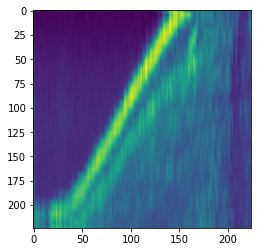

In [26]:
max_range = 5
min_range = 1
range_min = int(np.ceil(min_range/range_res))
range_max = int(np.ceil(max_range/range_res))

get_spectrogram('/media/NAS/MMWAVE_1642_10days/source/hmacharl/11_12/15_50_54.bin', 0)